In [ ]:
import numpy as np
import pydicom
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from glob import glob

In [2]:
GOLD_PATH = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset'
groups = {
    "Group 1 (Mask & Box)": os.path.join(GOLD_PATH, '1_mask_and_box'),
    "Group 2 (Only Mask)": os.path.join(GOLD_PATH, '2_only_mask'),
    "Group 3 (Only Box)": os.path.join(GOLD_PATH, '3_only_box')
}

GROUPS = ['1_mask_and_box', '2_only_mask', '3_only_box']
OUTPUT_BASE_DIR = os.path.join(GOLD_PATH, 'resampled_1mm_slices')
# 2단계 결과를 저장할 경로
WINDOWED_BASE_DIR = os.path.join(GOLD_PATH, 'windowed_bone_slices')
FINAL_DIR = os.path.join(GOLD_PATH, 'final_preprocessed')

## dicom, npy 방향 확인

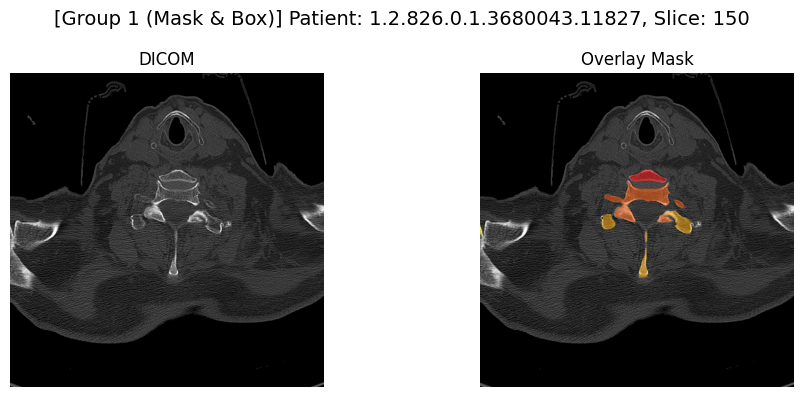

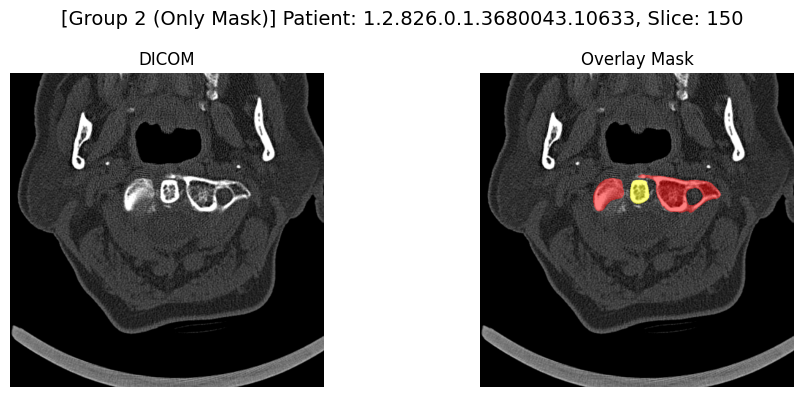

⏩ Group 3 (Only Box): 데이터 경로가 존재하지 않아 스킵합니다.


In [16]:
def check_all_groups(offset=100):
    for group_name, group_path in groups.items():
        img_root = os.path.join(group_path, 'train_images')
        mask_root = os.path.join(group_path, 'processed_masks')
        
        # 경로 존재 여부 확인
        if not os.path.exists(img_root) or not os.path.exists(mask_root):
            print(f"⏩ {group_name}: 데이터 경로가 존재하지 않아 스킵합니다.")
            continue

        # 해당 그룹의 첫 번째 환자 ID 가져오기
        patient_ids = sorted([d for d in os.listdir(img_root) if os.path.isdir(os.path.join(img_root, d))])
        if not patient_ids:
            print(f"⏩ {group_name}: 환자 폴더가 비어있습니다.")
            continue
        
        target_pid = patient_ids[0]
        img_dir = os.path.join(img_root, target_pid)
        mask_dir = os.path.join(mask_root, target_pid)

        # 파일 목록 정렬 (숫자 기반)
        dcm_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.dcm')], 
                           key=lambda x: int(''.join(filter(str.isdigit, x))))
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.npy')],
                            key=lambda x: int(''.join(filter(str.isdigit, x))))

        if not dcm_files or not mask_files:
            print(f"⏩ {group_name}: {target_pid} 환자의 이미지나 마스크가 부족합니다.")
            continue

        # 인덱스 범위 초과 방지
        idx = min(offset, len(dcm_files)-1, len(mask_files)-1)

        # DICOM 로드 및 윈도잉
        ds = pydicom.dcmread(os.path.join(img_dir, dcm_files[idx]))
        img = ds.pixel_array.astype(np.float32)
        slope = float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0
        intercept = float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
        hu_img = img * slope + intercept
        windowed_img = np.clip(hu_img, 450 - 750, 450 + 750) 

        # Mask 로드
        mask = np.load(os.path.join(mask_dir, mask_files[idx]))

        # 시각화
        plt.figure(figsize=(10, 4))
        plt.suptitle(f"[{group_name}] Patient: {target_pid}, Slice: {idx}", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(windowed_img, cmap='gray')
        plt.title(f"DICOM")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # 마스크가 있으면 투명도 오버레이, 없으면(모두 0) 그냥 출력
        plt.imshow(windowed_img, cmap='gray')
        masked_data = np.ma.masked_where(mask == 0, mask)
        plt.imshow(masked_data, cmap='autumn', alpha=0.5)
        plt.title(f"Overlay Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 실행
check_all_groups(offset=150)

## 통합 전처리 코드(87명 적용)

In [18]:
import os
import pydicom
import numpy as np
from scipy.ndimage import zoom
from tqdm import tqdm

# 1. 경로 설정 (동일)
BASE_PATH = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\2_only_mask'
IMG_ROOT = os.path.join(BASE_PATH, 'train_images')
MASK_ROOT = os.path.join(BASE_PATH, 'processed_masks')
SAVE_ROOT = os.path.join(BASE_PATH, 'final_preprocessed')

os.makedirs(SAVE_ROOT, exist_ok=True)

# 2. 하이퍼파라미터 설정
TARGET_Z = 128
TARGET_SIZE = 224
WL = 500
WW = 2000
PADDING = 10 # 범위를 좁혔으므로 패딩을 살짝 줄여도 무방합니다.

def apply_windowing(img, wl, ww):
    img_min = wl - ww // 2
    img_max = wl + ww // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min)
    return img.astype(np.float32)

def process_gold_patient(pid):
    p_img_dir = os.path.join(IMG_ROOT, pid)
    p_mask_dir = os.path.join(MASK_ROOT, pid)
    
    dcm_files = sorted([f for f in os.listdir(p_img_dir) if f.endswith('.dcm')], 
                       key=lambda x: int(os.path.splitext(x)[0]))
    mask_files = sorted([f for f in os.listdir(p_mask_dir) if f.endswith('.npy')],
                        key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]) if '_' in x else int(os.path.splitext(x)[0]))

    if len(dcm_files) != len(mask_files):
        return

    imgs, masks = [], []
    for dcm_f, npy_f in zip(dcm_files, mask_files):
        ds = pydicom.dcmread(os.path.join(p_img_dir, dcm_f))
        img = ds.pixel_array.astype(np.float32)
        img = img * float(ds.RescaleSlope) + float(ds.RescaleIntercept)
        imgs.append(img)
        masks.append(np.load(os.path.join(p_mask_dir, npy_f)))

    img_vol = np.stack(imgs, axis=0) 
    mask_vol = np.stack(masks, axis=0)

    # ⭐ C. ROI(C1~T2) 탐색 및 크롭
    # 1~7(경추) + 8~9(T1, T2)가 있는 슬라이스만 찾습니다.
    z_indices = np.where((mask_vol >= 1) & (mask_vol <= 9))[0]
    
    if len(z_indices) > 0:
        z_min = max(0, z_indices.min() - PADDING)
        z_max = min(img_vol.shape[0], z_indices.max() + PADDING)
        img_vol = img_vol[z_min:z_max]
        mask_vol = mask_vol[z_min:z_max]

    # D. Windowing 적용 (500 / 2000)
    img_vol = apply_windowing(img_vol, WL, WW)

    # E. Resampling & Resizing (128, 224, 224)
    z_factor = TARGET_Z / img_vol.shape[0]
    xy_factor = TARGET_SIZE / img_vol.shape[2] # 512 대비 유연하게 대응
    
    img_final = zoom(img_vol, (z_factor, xy_factor, xy_factor), order=1)
    mask_final = zoom(mask_vol, (z_factor, xy_factor, xy_factor), order=0)

    # F. 저장
    np.save(os.path.join(SAVE_ROOT, f"{pid}_img.npy"), img_final)
    np.save(os.path.join(SAVE_ROOT, f"{pid}_mask.npy"), mask_final)

# 3. 메인 루프 실행
patient_ids = [d for d in os.listdir(IMG_ROOT) if os.path.isdir(os.path.join(IMG_ROOT, d))]
for pid in tqdm(patient_ids):
    try:
        process_gold_patient(pid)
    except Exception as e:
        print(f"❌ {pid} 오류: {e}")

100%|██████████| 47/47 [05:43<00:00,  7.31s/it]


## 전처리 시각화 확인

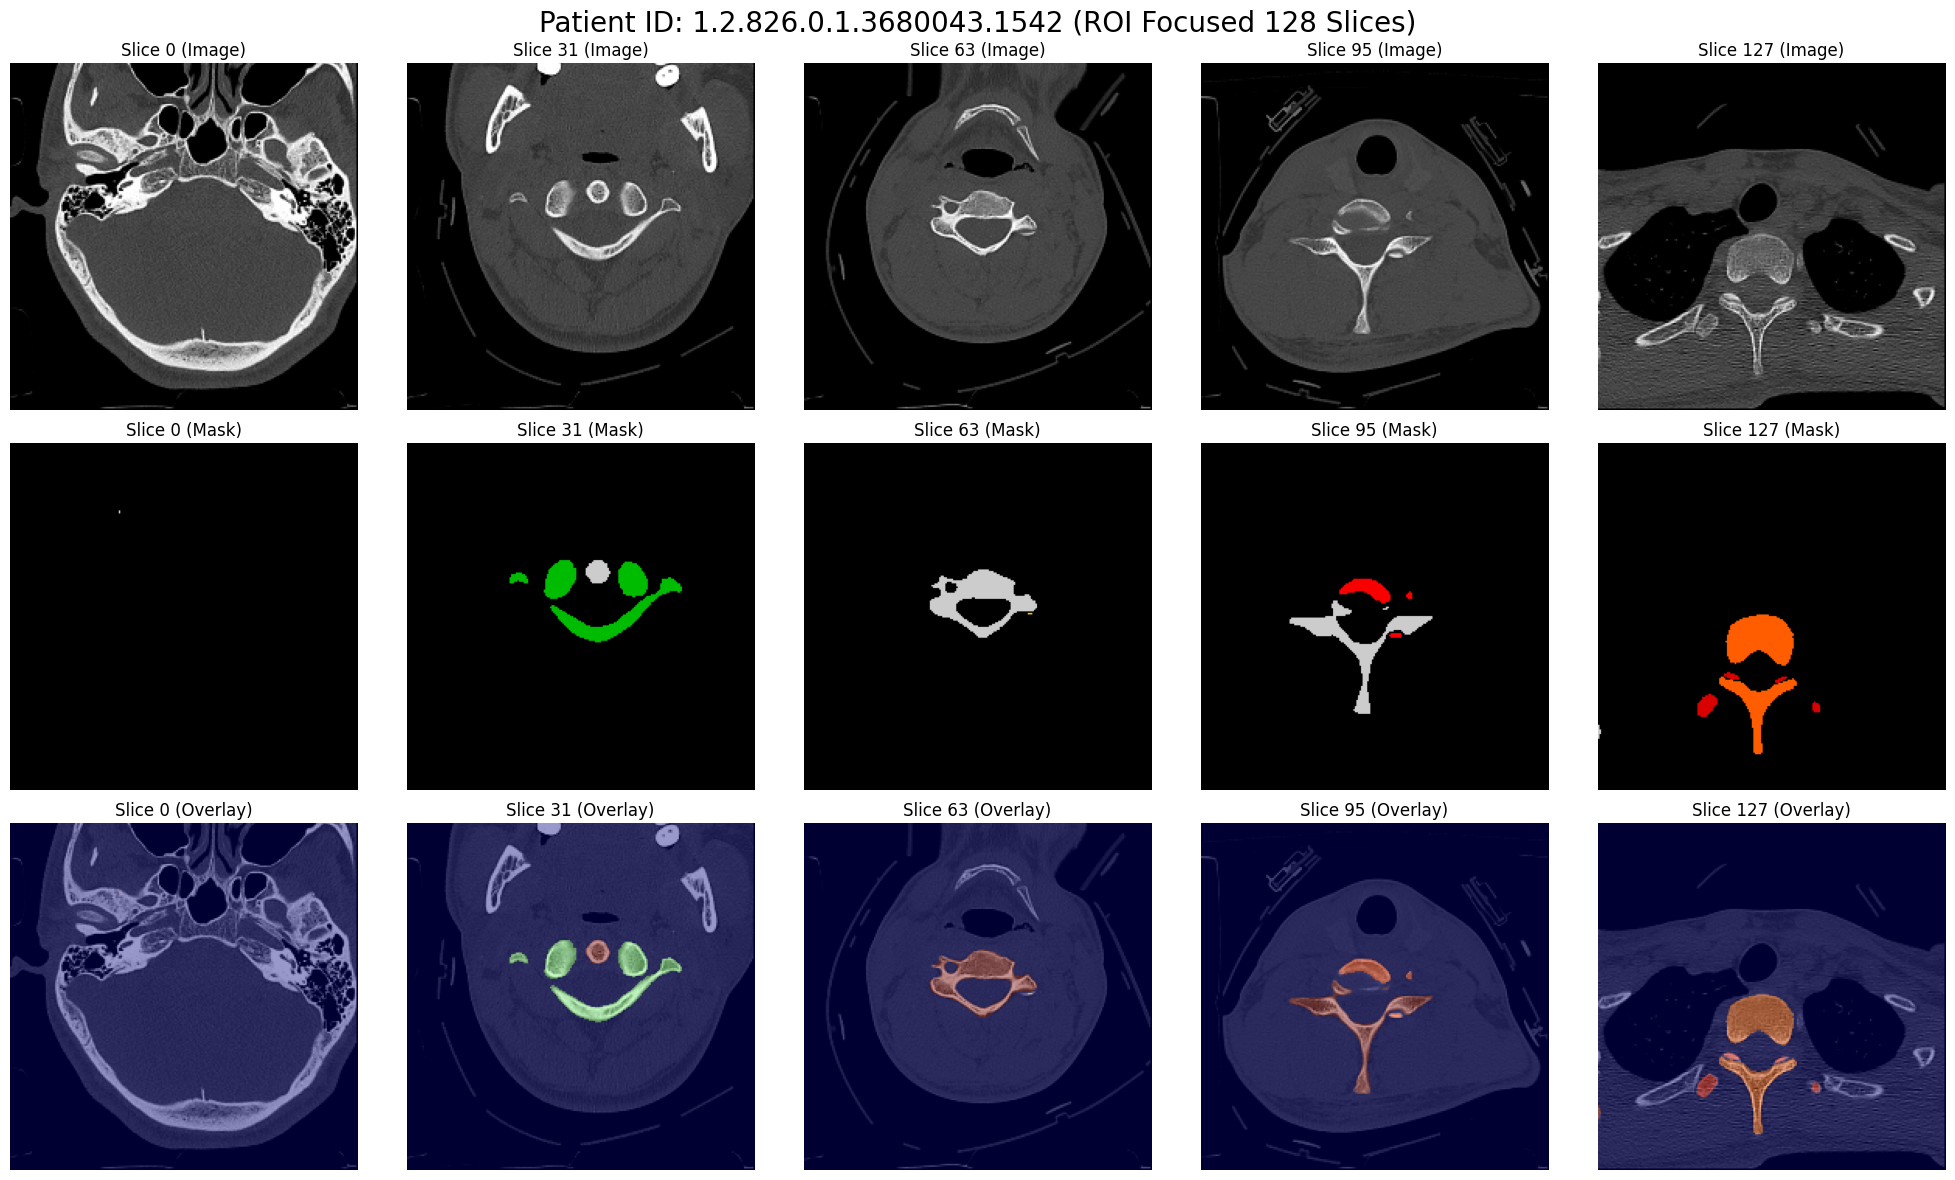

In [19]:
def visualize_preprocessed_data(pid, save_root):
    # 1. 데이터 로드
    img_path = os.path.join(save_root, f"{pid}_img.npy")
    mask_path = os.path.join(save_root, f"{pid}_mask.npy")
    
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        print(f"❌ {pid}의 전처리 파일을 찾을 수 없습니다.")
        return

    img_vol = np.load(img_path)   # (128, 224, 224)
    mask_vol = np.load(mask_path) # (128, 224, 224)

    # 2. 시각화할 슬라이스 선택 (전체 128장 중 5개 추출)
    indices = np.linspace(0, 127, 5).astype(int)
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    plt.suptitle(f"Patient ID: {pid} (ROI Focused 128 Slices)", fontsize=20)

    for i, idx in enumerate(indices):
        # 첫 번째 행: 원본 이미지 (Windowing 완료된 상태)
        axes[0, i].imshow(img_vol[idx], cmap='gray')
        axes[0, i].set_title(f"Slice {idx} (Image)")
        axes[0, i].axis('off')

        # 두 번째 행: 정답 마스크 (C1~C7 라벨별 색상)
        axes[1, i].imshow(mask_vol[idx], cmap='nipy_spectral')
        axes[1, i].set_title(f"Slice {idx} (Mask)")
        axes[1, i].axis('off')

        # 세 번째 행: 오버레이 (이미지 위에 마스크를 반투명하게)
        axes[2, i].imshow(img_vol[idx], cmap='gray')
        axes[2, i].imshow(mask_vol[idx], cmap='jet', alpha=0.4 if mask_vol[idx].max() > 0 else 0)
        axes[2, i].set_title(f"Slice {idx} (Overlay)")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# 사용 - 전처리 완료된 폴더 경로와 환자 ID 입력
sample_pid = '1.2.826.0.1.3680043.1542' # 실제 존재하는 ID로 변경해서 쓰세요!
visualize_preprocessed_data(sample_pid, FINAL_DIR)

## 뼈지도 시각화

In [29]:
import numpy as np
import os
from glob import glob

SAVE_ROOT = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\2_only_mask\final_preprocessed'

def ultimate_data_audit(data_dir):
    mask_files = sorted(glob(os.path.join(data_dir, "*_mask.npy")))
    blacklist = []
    
    print(f"🔬 {len(mask_files)}명의 데이터를 '분자 단위'로 검사합니다...")

    for f_path in mask_files:
        pid = os.path.basename(f_path).replace('_mask.npy', '')
        mask_vol = np.load(f_path) # (128, 224, 224)
        
        issues = []
        for label in range(1, 10):
            # 해당 라벨이 존재하는 모든 Z 인덱스 추출
            z_indices = np.unique(np.where(mask_vol == label)[0])
            
            if len(z_indices) > 0:
                # 1. 파편화(Fragmentation) 체크
                # 뼈는 연속적이어야 함. 중간에 3장 이상 비어있으면 유령 라벨임.
                gaps = np.diff(z_indices)
                if np.any(gaps > 3):
                    max_gap = np.max(gaps)
                    issues.append(f"{label}번 뼈 중간 끊김(최대 {max_gap}장 공백)")

                # 2. 비정상적 길이 (노이즈 때문에 바가 길게 늘어지는 경우)
                span = z_indices.max() - z_indices.min() + 1
                if span > 45:
                    issues.append(f"{label}번 뼈 길이 비정상({span}장)")

                # 3. 위치 역전 (가장 확실한 물리적 법칙)
                # 이 아래는 앞선 라벨들과 비교
                for prev_label in range(1, label):
                    prev_z = np.unique(np.where(mask_vol == prev_label)[0])
                    if len(prev_z) > 0:
                        # 앞 번호 뼈의 끝보다 뒷 번호 뼈의 시작이 너무 앞서면 역전
                        if prev_z.mean() > z_indices.mean(): 
                            issues.append(f"{prev_label}번-{label}번 평균 위치 역전")

        if issues:
            blacklist.append({'pid': pid, 'issues': list(set(issues))}) # 중복 제거

    return blacklist

# 실행
final_blacklist = ultimate_data_audit(SAVE_ROOT)

if not final_blacklist:
    print("\n😱 이래도 0명이라고요? 그렇다면 '시각화 코드'의 버그일 가능성이 매우 높습니다!")
else:
    print(f"\n🚨 드디어 {len(final_blacklist)}명의 범인을 검거했습니다!")
    for b in final_blacklist:
        print(f"[{b['pid']}] -> {', '.join(b['issues'])}")

🔬 0명의 데이터를 '분자 단위'로 검사합니다...

😱 이래도 0명이라고요? 그렇다면 '시각화 코드'의 버그일 가능성이 매우 높습니다!


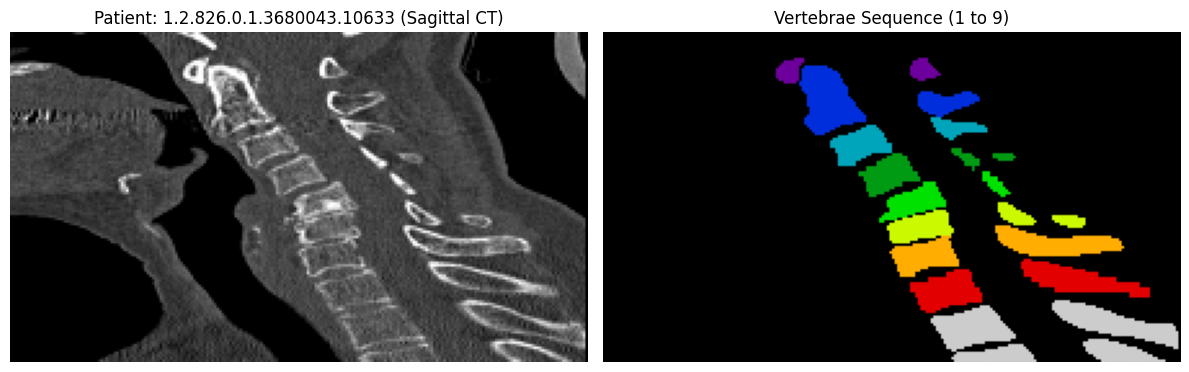

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. 경로 설정
SAVE_ROOT = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\final_preprocessed'

def visualize_sagittal_check(patient_id):
    img_path = os.path.join(SAVE_ROOT, f"{patient_id}_img.npy")
    mask_path = os.path.join(SAVE_ROOT, f"{patient_id}_mask.npy")
    
    img_vol = np.load(img_path)   # (128, 224, 224)
    mask_vol = np.load(mask_path)
    
    # 볼륨의 정중앙(옆면)을 자릅니다.
    mid_x = img_vol.shape[2] // 2
    sagittal_img = img_vol[:, :, mid_x]
    sagittal_mask = mask_vol[:, :, mid_x]

    plt.figure(figsize=(12, 6))
    
    # 1. 원본 CT 옆모습
    plt.subplot(1, 2, 1)
    plt.imshow(sagittal_img, cmap='gray')
    plt.title(f"Patient: {patient_id} (Sagittal CT)")
    plt.axis('off')
    
    # 2. 마스크 옆모습 (색깔별로 1~7번이 순서대로 있는지 확인!)
    plt.subplot(1, 2, 2)
    plt.imshow(sagittal_mask, cmap='nipy_spectral', vmin=0, vmax=9)
    plt.title("Vertebrae Sequence (1 to 9)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 아까 시각화에서 이상해 보였던 환자 ID를 여기에 넣으세요!
# 만약 없다면 첫 번째 환자로 테스트
patient_files = [f for f in os.listdir(SAVE_ROOT) if f.endswith('_mask.npy')]
test_pid = patient_files[0].replace('_mask.npy', '')
visualize_sagittal_check(test_pid)

✅ 총 87명의 환자 데이터 발견

🔍 Z-Position 정규화 검증

Vertebra   Mean Z_pos   Std        Expected     Status
-----------------------------------------------------------------
C1               0.240     0.220        0.05  ❌ CHECK
C2               0.268     0.152        0.15  ✅ GOOD
C3               0.361     0.103        0.25  ✅ GOOD
C4               0.465     0.058        0.35  ✅ GOOD
C5               0.569     0.069        0.45  ✅ GOOD
C6               0.640     0.068        0.58  ✅ GOOD
C7               0.680     0.157        0.70  ✅ GOOD
T1               0.752     0.205        0.85  ✅ GOOD
T2               0.809     0.245        0.95  ✅ GOOD


📋 개별 환자 상세 정보 (처음 3명)

🔸 Patient 1: 1.2.826.0.1.3680043.10633
   Vertebra Z_pos      Span(슬라이스 수)
   -----------------------------------
   C1           0.117              23
   C2           0.203              29
   C3           0.316              22
   C4           0.406              23
   C5           0.500              21
   C6           0.566          

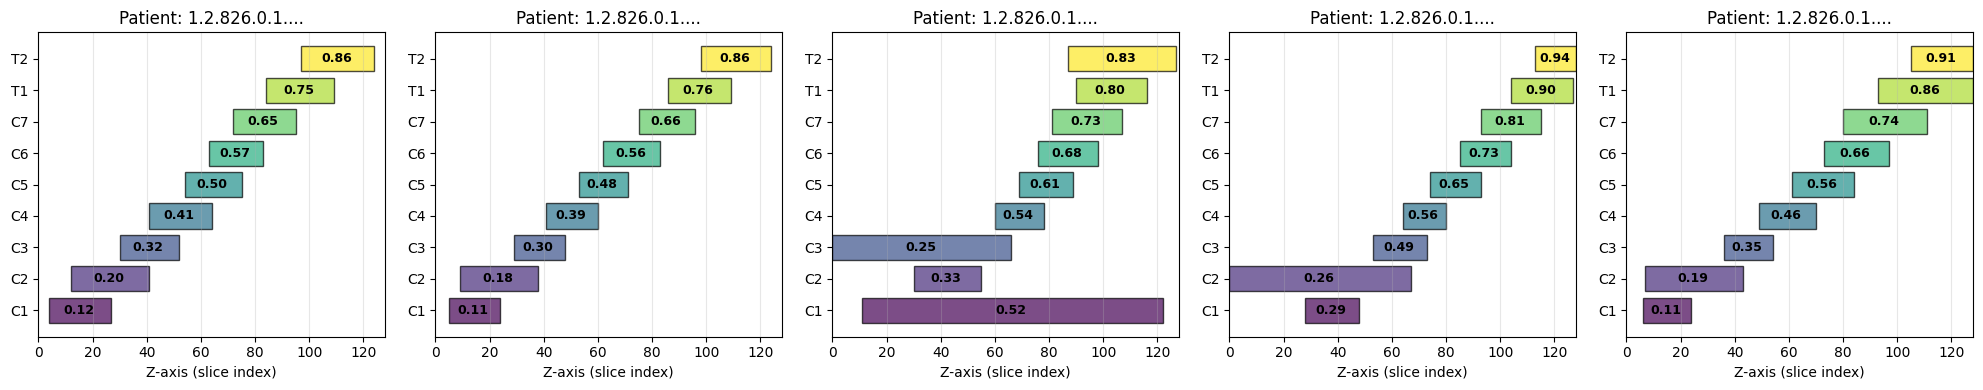


🔬 1.2.826.0.1.3680043.10633 환자의 슬라이스별 확인...


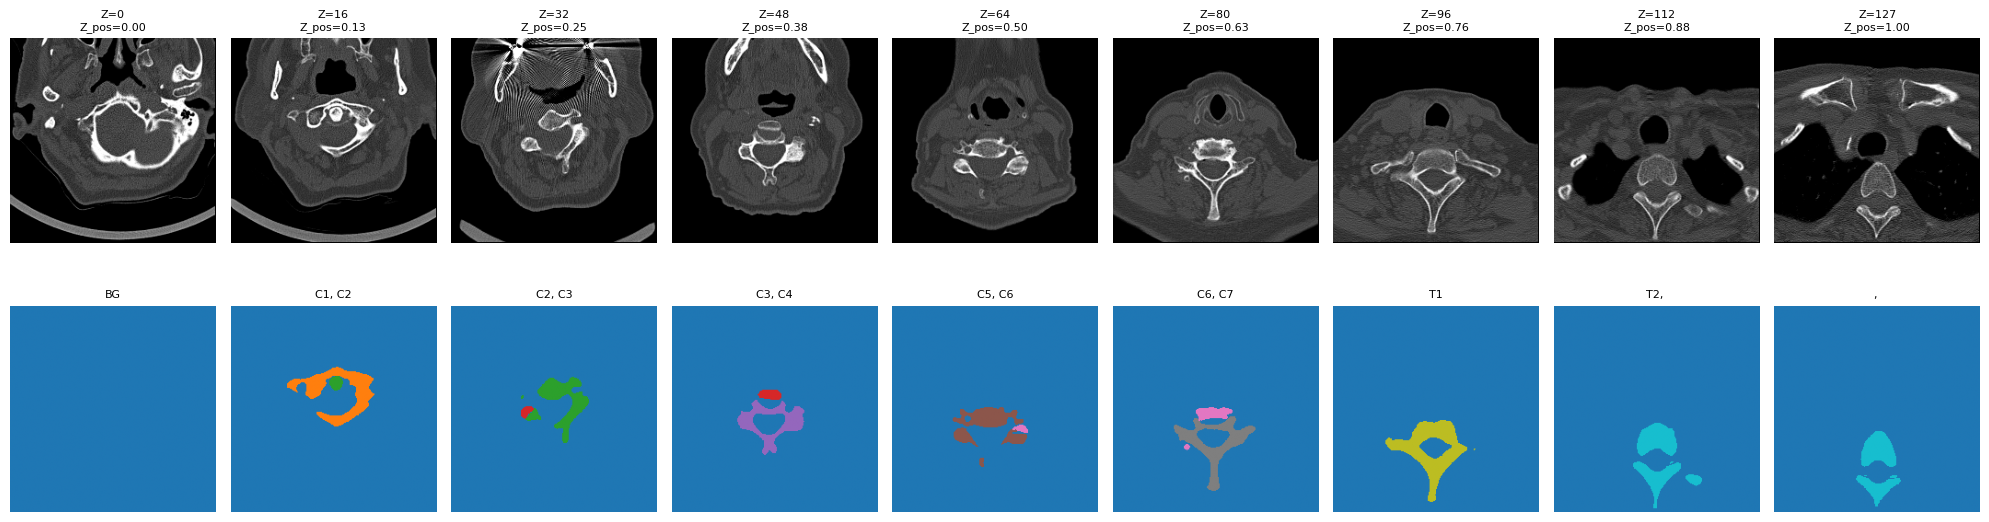


✅ 검증 완료!


In [20]:
def analyze_zpos_distribution(patient_id):
    """각 척추가 Z축의 어느 위치에 있는지 분석"""
    mask_path = os.path.join(FINAL_DIR, f"{patient_id}_mask.npy")
    mask_vol = np.load(mask_path)  # (128, 224, 224)
    
    vertebra_positions = {}
    
    for z in range(mask_vol.shape[0]):
        slice_mask = mask_vol[z]
        unique_labels = np.unique(slice_mask)
        
        for label in unique_labels:
            if 1 <= label <= 9:  # C1(1) ~ T2(9)
                if label not in vertebra_positions:
                    vertebra_positions[label] = []
                vertebra_positions[label].append(z)
    
    # 정규화된 Z 위치 계산
    vertebra_stats = {}
    total_depth = mask_vol.shape[0]
    
    for label, z_list in sorted(vertebra_positions.items()):
        z_min = min(z_list)
        z_max = max(z_list)
        z_center = (z_min + z_max) / 2
        
        z_pos_min = z_min / total_depth
        z_pos_max = z_max / total_depth
        z_pos_center = z_center / total_depth
        
        vertebra_name = {
            1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 
            5: 'C5', 6: 'C6', 7: 'C7', 8: 'T1', 9: 'T2'
        }[label]
        
        vertebra_stats[vertebra_name] = {
            'z_min': z_min,
            'z_max': z_max,
            'z_center': z_center,
            'z_pos_min': z_pos_min,
            'z_pos_max': z_pos_max,
            'z_pos_center': z_pos_center,
            'span': z_max - z_min + 1
        }
    
    return vertebra_stats, total_depth

def print_detailed_stats(patient_ids, n_samples=10):
    """상세 통계 출력"""
    print("="*80)
    print("🔍 Z-Position 정규화 검증")
    print("="*80)
    
    all_stats = []
    for pid in patient_ids[:n_samples]:
        try:
            stats, _ = analyze_zpos_distribution(pid)
            all_stats.append(stats)
        except Exception as e:
            print(f"⚠️ {pid} 스킵: {e}")
            continue
    
    # 척추별 평균 Z_pos 계산
    vertebra_names = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2']
    print(f"\n{'Vertebra':<10} {'Mean Z_pos':<12} {'Std':<10} {'Expected':<12} {'Status'}")
    print("-"*65)
    
    expected = {
        'C1': 0.05, 'C2': 0.15, 'C3': 0.25, 'C4': 0.35, 
        'C5': 0.45, 'C6': 0.58, 'C7': 0.70, 'T1': 0.85, 'T2': 0.95
    }
    
    for vname in vertebra_names:
        z_positions = []
        for stats in all_stats:
            if vname in stats:
                z_positions.append(stats[vname]['z_pos_center'])
        
        if z_positions:
            mean_z = np.mean(z_positions)
            std_z = np.std(z_positions)
            exp_z = expected[vname]
            
            # 오차가 ±0.15 이내면 ✅
            status = "✅ GOOD" if abs(mean_z - exp_z) < 0.15 else "❌ CHECK"
            
            print(f"{vname:<10} {mean_z:>11.3f} {std_z:>9.3f} {exp_z:>11.2f}  {status}")
    
    print("\n" + "="*80)
    
    # 개별 환자별 상세 정보
    print("\n📋 개별 환자 상세 정보 (처음 3명)")
    print("="*80)
    for i, (pid, stats) in enumerate(zip(patient_ids[:3], all_stats[:3])):
        print(f"\n🔸 Patient {i+1}: {pid}")
        print(f"   {'Vertebra':<8} {'Z_pos':<10} {'Span(슬라이스 수)'}")
        print("   " + "-"*35)
        for vname in vertebra_names:
            if vname in stats:
                s = stats[vname]
                print(f"   {vname:<8} {s['z_pos_center']:>9.3f} {s['span']:>15}")

def visualize_vertebra_distribution(patient_ids, n_samples=5):
    """여러 환자의 척추 분포 시각화 - 화면에만 표시"""
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 4))
    
    for idx, pid in enumerate(patient_ids[:n_samples]):
        stats, total_depth = analyze_zpos_distribution(pid)
        
        ax = axes[idx]
        vertebra_names = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2']
        colors = plt.cm.viridis(np.linspace(0, 1, 9))
        
        for i, vname in enumerate(vertebra_names):
            if vname in stats:
                s = stats[vname]
                ax.barh(i, s['span'], left=s['z_min'], 
                       color=colors[i], alpha=0.7, edgecolor='black')
                ax.text(s['z_center'], i, f"{s['z_pos_center']:.2f}", 
                       ha='center', va='center', fontsize=9, fontweight='bold')
        
        ax.set_yticks(range(9))
        ax.set_yticklabels(vertebra_names)
        ax.set_xlabel('Z-axis (slice index)')
        ax.set_title(f'Patient: {pid[:12]}...')
        ax.set_xlim(0, total_depth)
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_single_patient_slices(patient_id):
    """한 환자의 주요 슬라이스 시각화"""
    img_path = os.path.join(FINAL_DIR, f"{patient_id}_img.npy")
    mask_path = os.path.join(FINAL_DIR, f"{patient_id}_mask.npy")
    
    img_vol = np.load(img_path)
    mask_vol = np.load(mask_path)
    
    # 주요 Z 위치 선택
    z_positions = [0, 16, 32, 48, 64, 80, 96, 112, 127]
    z_pos_normalized = [z / 127 for z in z_positions]
    
    fig, axes = plt.subplots(2, len(z_positions), figsize=(20, 6))
    
    for i, z in enumerate(z_positions):
        # 이미지
        axes[0, i].imshow(img_vol[z], cmap='gray')
        axes[0, i].set_title(f'Z={z}\nZ_pos={z_pos_normalized[i]:.2f}', fontsize=8)
        axes[0, i].axis('off')
        
        # 마스크
        axes[1, i].imshow(mask_vol[z], cmap='tab10', vmin=0, vmax=10)
        unique_labels = np.unique(mask_vol[z])
        vertebra_text = ', '.join([{1:'C1',2:'C2',3:'C3',4:'C4',5:'C5',
                                    6:'C6',7:'C7',8:'T1',9:'T2'}.get(int(l), '') 
                                  for l in unique_labels if l > 0])
        axes[1, i].set_title(vertebra_text if vertebra_text else 'BG', fontsize=8)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# ===== 실행 =====
if __name__ == "__main__":
    patient_files = glob(os.path.join(FINAL_DIR, "*_mask.npy"))
    patient_ids = [os.path.basename(f).replace('_mask.npy', '') for f in patient_files]
    
    print(f"✅ 총 {len(patient_ids)}명의 환자 데이터 발견\n")
    
    if len(patient_ids) == 0:
        print("❌ 데이터를 찾을 수 없습니다. 경로를 확인하세요!")
    else:
        # 1. 상세 통계 출력
        print_detailed_stats(patient_ids, n_samples=min(10, len(patient_ids)))
        
        # 2. 척추 분포 시각화
        print("\n📊 척추 분포 시각화...")
        visualize_vertebra_distribution(patient_ids, n_samples=min(5, len(patient_ids)))
        
        # 3. 한 환자의 슬라이스별 확인
        print(f"\n🔬 {patient_ids[0]} 환자의 슬라이스별 확인...")
        visualize_single_patient_slices(patient_ids[0])
        
        print("\n✅ 검증 완료!")

## Train/val split

In [6]:
# 2. 폴더 내 파일들 중 환자 ID만 추출 (_img.npy 앞부분)
# 파일명이 '1.2.3..._img.npy' 형태라고 가정합니다.
all_files = os.listdir(FINAL_DIR)
patient_ids = sorted(list(set([f.replace('_img.npy', '') for f in all_files if f.endswith('_img.npy')])))

if not patient_ids:
    print(f"⚠️ 해당 경로에서 전처리된 이미지 파일을 찾을 수 없습니다: {FINAL_DIR}")
else:
    # 3. 8:2 비율로 나누기 (seed 42 고정)
    train_ids, val_ids = train_test_split(
        patient_ids, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    # 4. 같은 폴더에 txt 파일로 저장
    def save_list(id_list, filename):
        save_path = os.path.join(GOLD_PATH, filename)
        with open(save_path, 'w') as f:
            for pid in id_list:
                f.write(f"{pid}\n")
        print(f"✅ {filename} 저장 완료 -> 위치: {save_path}")

    save_list(train_ids, 'train_patients.txt')
    save_list(val_ids, 'val_patients.txt')

    print("\n--- 최종 분리 결과 ---")
    print(f"📍 데이터 경로: {FINAL_DIR}")
    print(f"👥 전체 환자: {len(patient_ids)}명")
    print(f"🏋️ 학습용(Train): {len(train_ids)}명")
    print(f"🧪 검증용(Val): {len(val_ids)}명")

✅ train_patients.txt 저장 완료 -> 위치: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\train_patients.txt
✅ val_patients.txt 저장 완료 -> 위치: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\val_patients.txt

--- 최종 분리 결과 ---
📍 데이터 경로: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset\final_preprocessed
👥 전체 환자: 87명
🏋️ 학습용(Train): 69명
🧪 검증용(Val): 18명
